## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
#Spliting into Train and Test with a sample size of 95:5 

random.seed(1234)
train_set, valid_set = train_test_split(nltk_data,test_size=0.05)
print(len(train_set))
print(len(valid_set))

3718
196


In [5]:
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95749

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Dr.',
 'Talcott',
 'led',
 'a',
 'team',
 'of',
 'researchers',
 'from',
 'the',
 'National']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12080


In [43]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'X', 'PRON', 'DET', 'ADP', '.', 'ADV', 'PRT', 'NUM', 'NOUN', 'ADJ', 'CONJ', 'VERB'}


In [44]:
tag = [pair[1] for pair in train_tagged_words]
from collections import Counter
tag_counts = Counter(tag)
tag_counts

Counter({'NOUN': 27525,
         'VERB': 12902,
         'DET': 8307,
         'ADP': 9343,
         'CONJ': 2170,
         'ADJ': 6063,
         '.': 11140,
         'X': 6278,
         'ADV': 3015,
         'PRT': 3066,
         'NUM': 3344,
         'PRON': 2596})

In [45]:
# the most common tags can be seen using the most_common() method of Counter
tag_counts.most_common(5)

[('NOUN', 27525), ('VERB', 12902), ('.', 11140), ('ADP', 9343), ('DET', 8307)]

## Emission Probabilities

In [46]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [47]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [48]:
# examples

# large
print("\n", "Andriod")
print(word_given_tag('Andriod', 'ADP'))
print(word_given_tag('Andriod', 'VERB'))
print(word_given_tag('Andriod', '.'))
print(word_given_tag('Andriod', 'DET'))
print(word_given_tag('Andriod', 'NOUN'), "\n")




 Andriod
(0, 9343)
(0, 12902)
(0, 11140)
(0, 8307)
(0, 27525) 



## Transition Probabilities

In [49]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [50]:
# examples
print(t2_given_t1(t2='NOUN', t1='VERB'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('VERB', 'NOUN'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(1440, 12902)
(5311, 8307)
(4046, 27525)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


In [60]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [61]:
tags_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [62]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [63]:
tags_df

,X,PRON,DET,ADP,.,ADV,PRT,NUM,NOUN,ADJ,CONJ,VERB
X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NUM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOUN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
tags_df.loc['.', :]

X       0.026840
PRON    0.064811
DET     0.173878
ADP     0.091472
.       0.092998
ADV     0.051885
PRT     0.002334
NUM     0.080700
NOUN    0.222890
ADJ     0.043627
CONJ    0.059156
VERB    0.089318
Name: ., dtype: float32

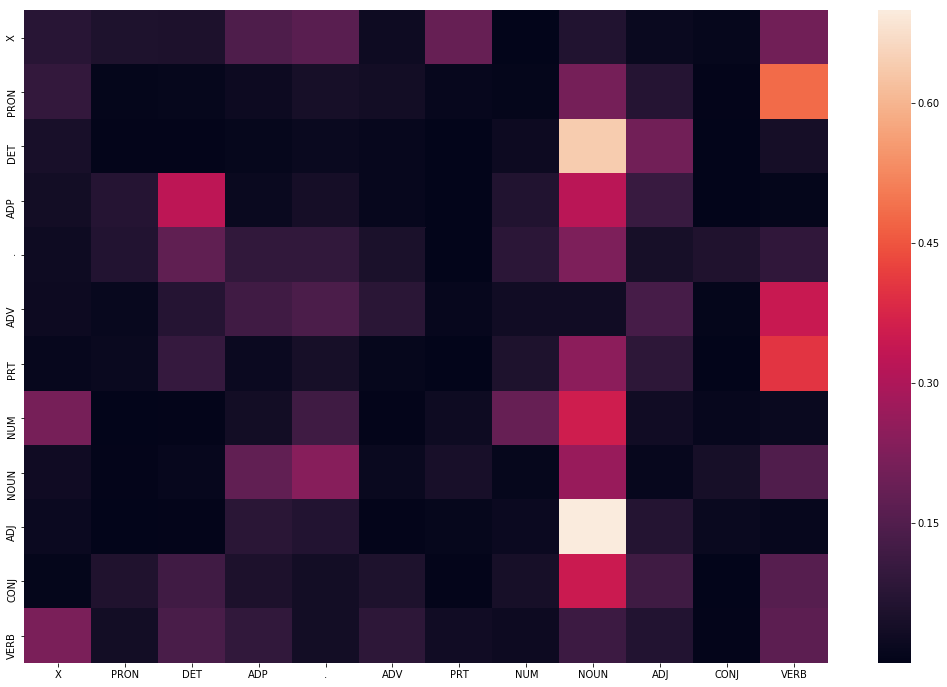

In [21]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

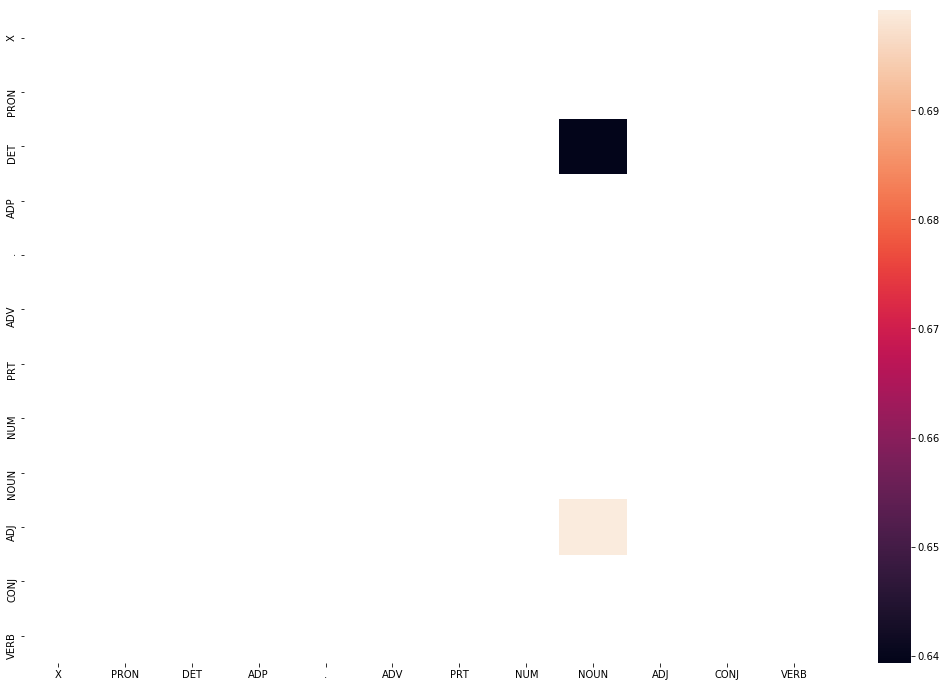

In [22]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [23]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [24]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(valid_set)) for x in range(10)]

# list of sents
test_run = [valid_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('But', 'CONJ'),
  ('many', 'ADJ'),
  ('others', 'NOUN'),
  ('have', 'VERB'),
  ('fallen', 'VERB'),
  ('through', 'ADP'),
  ('cracks', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('economy', 'NOUN'),
  ('into', 'ADP'),
  ('the', 'DET'),
  ('grim', 'ADJ'),
  (',', '.'),
  ('brutal', 'ADJ'),
  ('world', 'NOUN'),
  ('of', 'ADP'),
  ('our', 'PRON'),
  ('city', 'NOUN'),
  ('streets', 'NOUN'),
  ('.', '.')],
 [('Manufacturers', 'NOUN'),
  ("'", 'PRT'),
  ('backlogs', 'NOUN'),
  ('of', 'ADP'),
  ('unfilled', 'ADJ'),
  ('orders', 'NOUN'),
  ('rose', 'VERB'),
  ('0.5', 'NUM'),
  ('%', 'NOUN'),
  ('in', 'ADP'),
  ('September', 'NOUN'),
  ('to', 'PRT'),
  ('$', '.'),
  ('497.34', 'NUM'),
  ('billion', 'NUM'),
  ('*U*', 'X'),
  (',', '.'),
  ('*-3', 'X'),
  ('helped', 'VERB'),
  ('*-2', 'X'),
  ('by', 'ADP'),
  ('strength', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('defense', 'NOUN'),
  ('capital', 'NOUN'),
  ('goods', 'NOUN'),
  ('sector', 'NOUN'),
  ('.', '.')],
 [('Mrs.', 'NOUN'),
  ('

In [25]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [26]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  39.82056760787964
[('But', 'CONJ'), ('many', 'ADJ'), ('others', 'NOUN'), ('have', 'VERB'), ('fallen', 'VERB'), ('through', 'ADP'), ('cracks', 'X'), ('in', 'ADP'), ('the', 'DET'), ('economy', 'NOUN'), ('into', 'ADP'), ('the', 'DET'), ('grim', 'X'), (',', '.'), ('brutal', 'X'), ('world', 'NOUN'), ('of', 'ADP'), ('our', 'PRON'), ('city', 'NOUN'), ('streets', 'NOUN'), ('.', '.'), ('Manufacturers', 'NOUN'), ("'", 'PRT'), ('backlogs', 'NOUN'), ('of', 'ADP'), ('unfilled', 'X'), ('orders', 'NOUN'), ('rose', 'VERB'), ('0.5', 'X'), ('%', 'NOUN'), ('in', 'ADP'), ('September', 'NOUN'), ('to', 'PRT'), ('$', '.'), ('497.34', 'X'), ('billion', 'NUM'), ('*U*', 'X'), (',', '.'), ('*-3', 'X'), ('helped', 'VERB'), ('*-2', 'X'), ('by', 'ADP'), ('strength', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('defense', 'NOUN'), ('capital', 'NOUN'), ('goods', 'NOUN'), ('sector', 'NOUN'), ('.', '.'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('was', 'VERB'), ('fired', 'VERB'), ('*-1', 'X'), ('and',

In [27]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [28]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9273356401384083

In [29]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [30]:
incorrect_tagged_cases

[[('through', 'ADP'), (('cracks', 'X'), ('cracks', 'NOUN'))],
 [('the', 'DET'), (('grim', 'X'), ('grim', 'ADJ'))],
 [(',', '.'), (('brutal', 'X'), ('brutal', 'ADJ'))],
 [('of', 'ADP'), (('unfilled', 'X'), ('unfilled', 'ADJ'))],
 [('rose', 'VERB'), (('0.5', 'X'), ('0.5', 'NUM'))],
 [('$', '.'), (('497.34', 'X'), ('497.34', 'NUM'))],
 [('and', 'CONJ'), (('prosecuted', 'X'), ('prosecuted', 'VERB'))],
 [('law', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('questions', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('was', 'VERB'), (('coincidental', 'X'), ('coincidental', 'ADJ'))],
 [('.', '.'), (('Spreads', 'X'), ('Spreads', 'NOUN'))],
 [('so', 'ADV'), (('tight', 'ADJ'), ('tight', 'ADV'))],
 [("n't", 'ADV'), (('matter', 'NOUN'), ('matter', 'VERB'))],
 [('any', 'DET'), (('temporary', 'X'), ('temporary', 'ADJ'))],
 [('other', 'ADJ'), (('arrangements', 'X'), ('arrangements', 'NOUN'))],
 [('authorities', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('``', '.'), (('excess', 'NOUN'), ('e

In [31]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [32]:
print(tagged_seq)
print(difference)

[('Twitter', 'X'), ('is', 'VERB'), ('the', 'DET'), ('best', 'ADJ'), ('networking', 'NOUN'), ('social', 'ADJ'), ('site', 'X'), ('.', '.'), ('Man', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('social', 'ADJ'), ('animal', 'X'), ('.', '.'), ('Data', 'NOUN'), ('science', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('emerging', 'VERB'), ('field', 'NOUN'), ('.', '.'), ('Data', 'NOUN'), ('science', 'NOUN'), ('jobs', 'NOUN'), ('are', 'VERB'), ('high', 'ADJ'), ('in', 'ADP'), ('demand', 'NOUN'), ('.', '.')]
3.910346031188965


### Solve the problem of unknown words

#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications